In [1]:
import re
import nltk
import unicodedata
import os
from tqdm.auto import tqdm

# Read data that formed by WikiExtractor

In [2]:
from os import walk

wiki_pages = []
for (dirpath, dirnames, filenames) in walk("wiki_categories"):
    for a in filenames:
        wiki_pages.append(dirpath+"/"+a)

In [3]:
# this function replaces characters with accents
def strip_accents(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                  if unicodedata.category(c) != 'Mn')

In [4]:
#read categories that we needed
root_cats = []
with open("categoryies.txt",) as f:
    data = f.read()
    for line in data.split("\n"):
        root_cats.append(line.strip().replace("_", " "))


In [5]:
titles = []
with open("titles.csv",) as f:
    data = f.read()
    for line in data.split("\n"):
        titles.append(line.strip())
        

In [19]:
titles = list(map(lambda x: x.replace("_", ' '), titles))
titles = list(map(lambda x: x.replace("\"", ''), titles))

In [7]:
cats_dictionary = {x:[] for x in root_cats}
root_cats = set(root_cats)

In [8]:
categ = []

In [24]:
# get all pages

page_count = 0
exception_1 = 0
exception_2 = 0
exception_list = []
# how many senetnece we want from the page
MAX_SENTENCE = 5
for fi in tqdm(wiki_pages):
    data = open(fi).read()
    data = re.split(r"<doc",data)[1:]

    for i, page in enumerate(data):
        try:
            header, body = re.split(r">\n.*", page.strip())[:2]
        except:
            exception_1 +=1
            exception_list.append(page)
            continue
        try:
            m=re.search(r"(title=\"(.*)\" )", header)
            t = m.group(2)
            t = t.replace('"', "")
        except:
            exception_2 +=1
            continue        
        if t in titles:
            page_count += 1
            
            body = re.sub('\n\n', "\n", body)
            body = re.sub('\n', "", body)
            body = re.sub('[^А-Яа-я \.]+', "", body)
            body = strip_accents(body)
            body = nltk.sent_tokenize(body)[:MAX_SENTENCE]
            
            cats = re.search(r"(category=\"(.*)\")", header).group(2).split('|')
            cats = list(root_cats.intersection(cats))
            # sometimes page can be reletad to more then one category. We chose that have least pages
            if len(cats) > 0:
                minum = 999999999
                chosein_cat = ''
                for c in cats:
                    if len(cats_dictionary[c]) < minum:
                        chosein_cat = c
                        minum = len(cats_dictionary[c])
                cats_dictionary[chosein_cat].append(' '.join(body))
            else:

                continue
    

  0%|          | 0/7069 [00:00<?, ?it/s]

In [23]:
cats_dictionary

{'Распределённые вычисления': ['  открытая программная платформа университета Беркли для гридвычислении некоммерческое межплатформенное ПО для организации распределнных вычислении. Используется для организации добровольных вычислении. программныи комплекс для быстрои организации распределнных вычислении. Состоит из сервернои и клиентскои частеи. Первоначально разрабатывался для крупнеишего проекта добровольных вычислении  но впоследствии разработчики из Калифорнииского университета в Беркли сделали платформу доступнои для сторонних проектов.',
  ' проект фонда    свободно распространяемыи набор утилит библиотек и фреимворк для разработки и выполнения распределнных программ работающих на кластерах из сотен и тысяч узлов. Используется для реализации поисковых и контекстных механизмов многих высоконагруженных вебсаитов в том числе для  и . Разработан на  в рамках вычислительнои парадигмы  согласно которои приложение разделяется на большое количество одинаковых элементарных задании выполни

In [25]:
# check if exists categories without pages. 
#If does so, remove them from the tree either manually(in particular, if it leaves) in categoryies_classes.txt
# or automatically in category_investigation (don't forget to generate new categoryies_classes.txt)
# !! root can have zero pages.
for i,(k,v) in enumerate(cats_dictionary.items()):
    if len(v) == 0:
        print(i,k)

39 Википедия:Хорошие статьи по химии


# Forming dataset

In [26]:
classes = []
with open("categoryies_classes.txt",) as f:
    data = f.read()
    for line in data.split("\n"):
        classes.append(line.strip())
classes = classes[:-1]

In [27]:
df = {}

In [28]:
for cls in classes:
    cls_ = cls.split("/")[-1].replace("_", ' ')
    df[cls] = cats_dictionary[cls_]

In [29]:
import pandas as pd

In [30]:
df_ = pd.DataFrame(columns=['text', 'class'])

In [31]:
for c, texts in df.items():
    for t in texts:
        df_ = df_.append({'text': t.lower(), 'class': c}, ignore_index=True)

<AxesSubplot:>

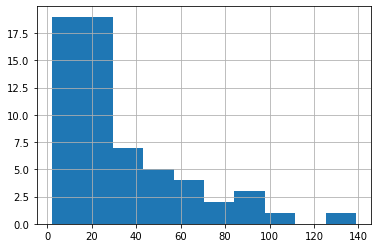

In [32]:
df_["class"].value_counts().hist()

In [33]:
len(df_["class"].unique())

61

In [44]:
df_.head(10)

,text,class
0,префиксныи код в теории кодирования код со сло...,Точные_науки/Информатика
1,в информатике и теории автоматов состояние циф...,Точные_науки/Информатика
2,скорость передачи данных объм данных передава...,Точные_науки/Информатика
3,естественная информатика это научное направлен...,Точные_науки/Информатика
4,геоматика совокупность применении информацион...,Точные_науки/Информатика
5,термины пользовательская разработка или по...,Точные_науки/Информатика
6,языковоориентированное программирование яоп т...,Точные_науки/Информатика
7,грамма последовательность из элементов. с сем...,Точные_науки/Информатика
8,андреи александрович берс июля свердловск я...,Точные_науки/Информатика
9,префиксныи код в теории кодирования код со сло...,Точные_науки/Информатика


In [45]:
len(df_)

2031

In [35]:
df_.to_csv("wiki_hierartical_dataset.csv", sep="|")